In [1]:
import pandas as pd
import numpy as np
from cataclop.ml.pipeline import factories

In [2]:
d = factories.Dataset.factory('default')
d.load(force=True)

In [3]:
pd.concat([pd.DataFrame(d.players.describe()).T, d.players.dtypes], axis=1, sort=True)

,count,mean,std,min,25%,50%,75%,max,0
age,32273.0,4.574164e+00,1.993099e+00,2.0,3.0,4.0,6.0,1.600000e+01,int64
category,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
condition_age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
condition_sex,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,category
date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,object
declared_player_count,32273.0,1.219614e+01,3.048985e+00,3.0,10.0,12.0,15.0,2.000000e+01,int64
distance,32273.0,1.953333e+03,4.894967e+02,800.0,1600.0,2000.0,2300.0,4.100000e+03,int64
earnings,32273.0,6.180678e+06,1.939113e+07,0.0,515000.0,2045000.0,6065000.0,1.471275e+09,int64


In [4]:
import time

df = d.players.groupby('race_id').filter(lambda race: race['race_count'].max() > 0)

races = df.groupby('race_id')

agg_features = ['race_count', 
                'victory_count', 
                'placed_2_count', 
                'placed_3_count',
                'victory_earnings',
                'prev_year_earnings',
                'handicap_distance',
                'handicap_weight'
               ]

stats = races[agg_features].agg([np.mean, np.std])
stats.columns = ['_'.join(col) for col in stats.columns.values]

df = df.join(stats, how='inner')

for f in agg_features:
    df['{}_r'.format(f)] = df[f] - df['{}_mean'.format(f)] / df['{}_std'.format(f)]
    
agg_features = ['{}_r'.format(f) for f in agg_features]

df[agg_features] = df[agg_features].replace([np.inf, -np.inf], np.nan)
df[agg_features] = df[agg_features].fillna(1000)

odds = pd.DataFrame(columns=['odds_{:d}'.format(i) for i in range(20)], index=df.index)

races = df.groupby('race_id')

start = time.time()

for (id, race) in races:
    odds_sorted = sorted(race['final_odds_ref'].values)
    odds.loc[race.index, ['odds_{:d}'.format(i) for i, v in enumerate(odds_sorted)]] = odds_sorted
    
end = time.time()
print(end - start)

df = pd.concat([df,odds], axis=1)

df[['odds_{:d}'.format(i) for i in range(20)]] = df[['odds_{:d}'.format(i) for i in range(20)]].fillna(1000.0)

df['speed'] = (df['distance'] / df['time']).fillna(1000)
df['final_odds_ref_inv'] = (1. / df['final_odds_ref']).fillna(0.)

df = df.groupby('race_id').filter(lambda r: r['position'].min() == 1)
df = df.sort_index()
df_orig = df.copy()

0.8349270820617676


In [5]:
df = df_orig[df_orig['category']=='ATTELE'].copy()
df = df.sort_index()

In [6]:
df_test = df[df['start_at'] > '2017-11-20'].copy()
df = df[df['start_at'] <= '2017-11-20'].copy()

In [7]:
len(df)


301

In [543]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, GroupKFold
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler

groups = df.index.droplevel(1).values

group_kfold = GroupKFold(n_splits=3)

features = agg_features

features = features + ['declared_player_count'] + ['hist_{}_pos'.format(i+1) for i in range(6)]

features = features + ['odds_{:d}'.format(i) for i in range(20)]

N_TARGETS = 6

df['pred_pos'] = N_TARGETS
for i in range(N_TARGETS):
    df['pred_{}'.format(i+1)] = 0.0

df['target'] = df['position'].copy()
df.loc[df['target'] > N_TARGETS, 'target'] = N_TARGETS-1
df['target'].fillna(N_TARGETS, inplace=True)

splits = list(group_kfold.split(df.values, df['position'].values, groups))

from cataclop.ml import preprocessing

models = [
    {
        'name': 'rf_10',
        'model': RandomForestClassifier(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'rf_30',
        'model': RandomForestClassifier(n_estimators=30),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestClassifier(n_estimators=100),
        'scaler': False
    },
    {
        'name': 'ada_10',
        'model': AdaBoostClassifier(n_estimators=10),
        'scaler': False
    },
    {
        'name': 'ada_30',
        'model': AdaBoostClassifier(n_estimators=30),
        'scaler': False
    },
    {
        'name': 'ada_100',
        'model': AdaBoostClassifier(n_estimators=100),
        'scaler': False
    },
    {
        'name': 'knn_10',
        'model': KNeighborsClassifier(n_neighbors=10),
        'scaler': False
    },
    {
        'name': 'knn_30',
        'model': KNeighborsClassifier(n_neighbors=30),
        'scaler': False
    },
    {
        'name': 'knn_100',
        'model': KNeighborsClassifier(n_neighbors=100),
        'scaler': False
    }
]
'''
    {
        'name': 'rf_150',
        'model': RandomForestClassifier(n_estimators=150),
        'scaler': False
    },
    {
        'name': 'rf_100',
        'model': RandomForestClassifier(n_estimators=100),
        'scaler': False
    },
{
    'name': 'nn_100',
    'model': MLPClassifier(),
    'scaler': True
}
{
    'name': 'knn_5',
    'model': KNeighborsClassifier(n_neighbors=5),
    'scaler': False
},
{
    'name': 'ada',
    'model': AdaBoostClassifier(),
    'scaler': False
},

{
    'name': 'rf_50',
    'model': RandomForestClassifier(n_estimators=50),
    'scaler': False
},
{
    'name': 'svc',
    'model': SVC(probability=True),
    'scaler': True
}
'''
for model in models:
    for i in range(N_TARGETS):
        df['pred_{}_{}'.format(model['name'], i+1)] = 0.0
        df_test['pred_{}_{}'.format(model['name'], i+1)] = 0.0

    df['pred_{}'.format(model['name'])] = 0.0

for train_index, test_index in splits:
    
    for model in models:

        X_train = df[features].iloc[train_index].copy()
        y_train = df['target'].iloc[train_index]

        dummies = preprocessing.get_dummies(df.iloc[train_index], ['sub_category'])
        X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
        
        X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
        y_train = df['target'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]

        X_test = df[features].iloc[test_index].copy()
        y_test = df['target'].iloc[test_index]
    
        X_val = df_test[features].copy()

        X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
        X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

        X_train = X_train.values
        X_test = X_test.values
        X_val = X_val.values

        idx = df.iloc[test_index].index

        if model['scaler']:
            scaler = StandardScaler()
            scaler.fit(X_train)

            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            X_val = scaler.transform(X_val)

        clf = model['model']
        clf.fit(X_train, y_train.values)

        p = clf.predict_proba(X_test)
    
        print( model['name'], log_loss(y_test.values, p) )

        for i in range(N_TARGETS):
            df.loc[idx, 'pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

        df.loc[idx, 'pred_{}'.format(model['name'])] = p[:, list(clf.classes_).index(1)]
    
        p = clf.predict_proba(X_val)
    
        for i in range(N_TARGETS):
            df_test['pred_{}_{}'.format(model['name'], i+1)] = p[:, list(clf.classes_).index(i+1)]

    
    
    
    

rf_10 6.00338206203798
rf_30 2.2437100374554855
rf_100 1.6383063962963038
ada_10 1.7614574747568421
ada_30 1.7718950952878738
ada_100 1.7763628905228064
knn_10 4.717778965966205
knn_30 1.8641899511046005
knn_100 1.5757839614653366
rf_10 6.3961052153890945
rf_30 2.0997549025768616
rf_100 1.613217918732686
ada_10 1.7573392628784859
ada_30 1.7724061827126896
ada_100 1.7814106599985122
knn_10 5.558310493640833
knn_30 1.827182961091824
knn_100 1.570091144072459
rf_10 6.28358619553296
rf_30 2.011866109869996
rf_100 1.672399092407492
ada_10 1.8151551104692645
ada_30 1.7796683701723885
ada_100 1.7780380111260738
knn_10 5.1735262037348475
knn_30 1.8715090960328842
knn_100 1.5756542200908794


In [655]:
from sklearn.linear_model import LogisticRegression

N_TARGETS_STACKED = 6

df['target_stacked'] = df['position'].copy()
df.loc[df['target_stacked'] > N_TARGETS_STACKED, 'target_stacked'] = N_TARGETS_STACKED-1
df['target_stacked'].fillna(N_TARGETS_STACKED, inplace=True)

df['pred_stacked'] = 0.0
for i in range(N_TARGETS_STACKED):
    df['pred_stacked_{}'.format(i+1)] = 0.0
    df_test['pred_stacked_{}'.format(i+1)] = 0.0


#stacked_features = ['pred_{}'.format(model['name']) for model in models]
stacked_features = []

for i in range(N_TARGETS):
    stacked_features = stacked_features + ['pred_{}_{}'.format(model['name'], i+1) for model in models]

#stacked_features = stacked_features + ['final_odds_ref_inv']

for train_index, test_index in splits:

    X_train = df[stacked_features].iloc[train_index].copy()
    y_train = df['target_stacked'].iloc[train_index]

    dummies = preprocessing.get_dummies(df.iloc[train_index], [])
    X_train = pd.concat([X_train, preprocessing.get_dummy_values(df.iloc[train_index], dummies)], axis=1)
    
    X_train = X_train[df.iloc[train_index]['final_odds_ref'] < 20]
    y_train = df['target_stacked'].iloc[train_index][df.iloc[train_index]['final_odds_ref'] < 20]


    X_test = df[stacked_features].iloc[test_index].copy()
    y_test = df['target_stacked'].iloc[test_index]
    
    X_val = df_test[stacked_features].copy()

    X_test = pd.concat([X_test, preprocessing.get_dummy_values(df.iloc[test_index], dummies)], axis=1)
    X_val = pd.concat([X_val, preprocessing.get_dummy_values(df_test, dummies)], axis=1)

    X_train = X_train.values
    X_test = X_test.values
    X_val = X_val.values

    idx = df.iloc[test_index].index
    
    scaler = Normalizer()
    scaler.fit(X_train)

    #X_train = scaler.transform(X_train)
    #X_test = scaler.transform(X_test)
    #X_val = scaler.transform(X_val)
    
    clf = MLPClassifier(hidden_layer_sizes=(100), activation='relu', batch_size=20)
    #clf = RandomForestClassifier(n_estimators=150)
    #clf = AdaBoostClassifier(n_estimators=250)
    #clf = SVC(probability=True)
    #clf = KNeighborsClassifier(n_neighbors=25)

    clf.fit(X_train, y_train.values)
    
    p = clf.predict_proba(X_test)
    
    #p = predict_proba_ordered(p, clf.classes_, classes)
    
    print( log_loss(y_test.values, p) )

    df.loc[idx, 'pred_stacked'] = p[:, list(clf.classes_).index(1)]
    for i in range(N_TARGETS_STACKED):
        df.loc[idx, 'pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]

    p = clf.predict_proba(X_val)
    
    for i in range(N_TARGETS_STACKED):
        df_test['pred_stacked_{}'.format(i+1)] = p[:, list(clf.classes_).index(i+1)]



1.7344796531708022
1.6519754920283791
1.5975909759900868


In [656]:
df_test[['position', 'final_odds_ref', 'pred_stacked_1']+['pred_{}_1'.format(m['name']) for m in models]][:10]

position  final_odds_ref  pred_stacked_1  pred_rf_10_1  \
race_id id                                                              
2160    15306      13.0            45.0        0.067129           0.2   
        15307       1.0             6.2        0.104036           0.2   
        15308       4.0             4.5        0.126559           0.2   
        15309      12.0            53.9        0.071609           0.0   
        15310       3.0            17.5        0.075202           0.2   
        15311       7.0            15.5        0.087534           0.0   
        15312       6.0             7.0        0.130319           0.1   
        15313       9.0            13.4        0.137359           0.1   
        15314      10.0             5.7        0.251843           0.2   
        15315       NaN            27.8        0.127440           0.2   

               pred_rf_30_1  pred_rf_100_1  pred_ada_10_1  pred_ada_30_1  \
race_id id                                                                 
2160    15306      0.066667           0.06       0.157156       0.166696   
        15307      0.066667           0.19       0.155619       0.160946   
        15308      0.266667           0.19       0.161898       0.160849   
        15309      0.100000           0.17       0.166951       0.161856   
        15310      0.100000           0.13       0.166951       0.162373   
        15311      0.166667           0.21       0.157156       0.161417   
        15312      0.066667           0.19       0.160609       0.163339   
        15313      0.066667           0.22       0.166951       0.177561   
        15314      0.133333           0.19       0.163453       0.165491   
        15315      0.100000           0.18       0.163453       0.168763   

               pred_ada_100_1  pred_knn_10_1  pred_knn_30_1  pred_knn_100_1  
race_id id                                                                   
2160    15306        0.139586            0.1       0.066667            0.13  
        15307        0.138296            0.0       0.066667            0.13  
        15308        0.139887            0.1       0.133333            0.17  
        15309        0.137024            0.1       0.100000            0.16  
        15310        0.138462            0.1       0.100000            0.13  
        15311        0.105486            0.0       0.100000            0.17  
        15312        0.106960            0.1       0.066667            0.13  
        15313        0.109841            0.0       0.166667            0.17  
        15314        0.139044            0.1       0.100000            0.16  
        15315        0.140327            0.2       0.166667            0.15

In [652]:
fi = pd.Series(clf.feature_importances_, index=stacked_features+preprocessing.get_dummy_features(dummies))
print(fi.sort_values(ascending=False))

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [667]:
#df_test['strat_1'] = df_test['pred_stacked_1']
#races = df_test.groupby('race_id')

#df['strat_1'] = df['pred_stacked_1']+df['pred_stacked_2']-df['pred_stacked_3']-df['pred_stacked_4']-df['pred_stacked_5']-df['pred_stacked_6']
df['strat_1'] = df['pred_stacked_1']
races = df.groupby('race_id')


bets = []

for (id, race) in races:
    
    nums = []
    
    for k, target in enumerate(['strat_1'], 1):
    
        r = race.sort_values(by=target, ascending=False)

        r = r[(r['final_odds_ref']<20.) & (r['final_odds_ref'] > 2)]

        if len(r) == 0:
            continue

        player = r.iloc[0]
        
        if player['num'] in nums:
            continue
            
        odds = player['final_odds_ref']
        
        '''
        
        if player['pred_1'] < 0.1:
            continue
        if player['pred_2'] < 0.075:
            continue
        if player['pred_3'] < 0.05:
            continue
            
        '''
        
        
        bet = 1#np.log(player['final_odds_ref'])#player['pred_1'] + player['pred_2']/2. + player['pred_3']/3.
        
        if odds < 3:
            bet = 100
        elif odds < 10:
            bet = 30
        else:
            bet = 10
            
        #bet = player['pred_stacked_1']*10

        profit = player['winner_dividend']/100.0 * bet - bet

        bets.append( (id, player['sub_category'], player['start_at'], bet, player['position'], player['final_odds'], player['pred_stacked_1'], player['pred_stacked_2'], player['pred_stacked_3'], player['num'], profit) )
        
        nums.append(player['num'])



bets = pd.DataFrame(bets, columns=['id', 'cat', 'date', 'bet', 'pos', 'odds', 'pred_1', 'pred_2', 'pred_3', 'num', 'profit'])


bets.index = bets['date']

bets = bets.sort_index()

bets['stash'] = bets['profit'].cumsum()


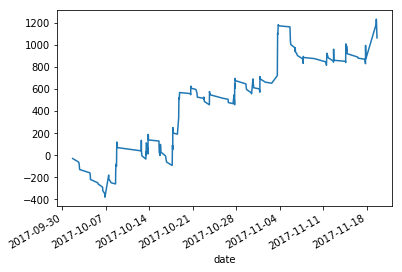

In [668]:
import matplotlib
%matplotlib inline
bets['stash'].plot()

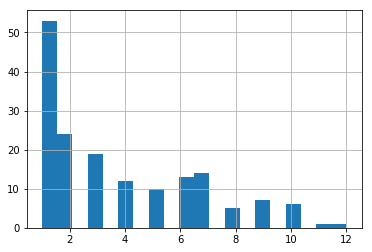

In [622]:
bets['pos'].hist(bins=20)

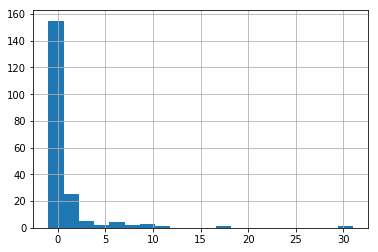

In [623]:
bets['profit'].hist(bins=20)

In [582]:
bets[0:100]

,id,cat,date,bet,pos,odds,pred_1,pred_2,pred_3,num,profit,stash
date,,,,,,,,,,,,
2017-10-01 16:15:00,29,AUTOSTART,2017-10-01 16:15:00,1.808330,6.0,22.5,0.180833,0.169924,0.105151,13,-1.808330,-1.808330
2017-10-02 13:47:00,30,EUROPEENNE_AUTOSTART,2017-10-02 13:47:00,1.726016,NaN,15.0,0.172602,0.166916,0.170662,14,-1.726016,-3.534346
2017-10-02 16:58:00,36,AUTOSTART,2017-10-02 16:58:00,1.679927,2.0,1.8,0.167993,0.173537,0.167440,6,-1.679927,-5.214273
2017-10-02 17:58:00,59,AUTOSTART,2017-10-02 17:58:00,1.710286,10.0,6.2,0.171029,0.151166,0.170616,4,-1.710286,-6.924559
2017-10-02 18:28:00,60,AUTOSTART,2017-10-02 18:28:00,1.880819,3.0,12.6,0.188082,0.173103,0.151420,2,-1.880819,-8.805378
2017-10-02 18:58:00,61,NATIONALE_AUTOSTART,2017-10-02 18:58:00,1.717641,2.0,7.0,0.171764,0.162320,0.150853,5,-1.717641,-10.523020
2017-10-02 19:28:00,62,NATIONALE_AUTOSTART,2017-10-02 19:28:00,1.738956,5.0,8.6,0.173896,0.143562,0.189120,8,-1.738956,-12.261975
2017-10-04 11:10:00,118,INTERNATIONALE_AUTOSTART,2017-10-04 11:10:00,1.840202,2.0,40.5,0.184020,0.178767,0.134270,9,-1.840202,-14.102178
2017-10-04 12:40:00,121,INTERNATIONALE_AUTOSTART,2017-10-04 12:40:00,1.723579,11.0,5.4,0.172358,0.171330,0.161107,12,-1.723579,-15.825757


cat     AMATEURS_AUTOSTART  AMATEURS_INTERNATIONALE_AUTOSTART  \
profit                -1.0                                0.8   
profit                 2.0                                1.0   

cat     APPRENTIS_LADS_JOCKEYS_AUTOSTART   AUTOSTART  A_RECLAMER_AUTOSTART  \
profit                              1.65   -0.300719                   2.1   
profit                              4.00  139.000000                   1.0   

cat     EUROPEENNE_AUTOSTART  GROUPE_I  GROUPE_II  INTERNATIONALE_AUTOSTART  \
profit             -0.588889      -1.0  -0.066667                 -0.382759   
profit              9.000000       1.0   3.000000                 29.000000   

cat     NATIONALE_AUTOSTART  
profit                  1.3  
profit                 10.0  


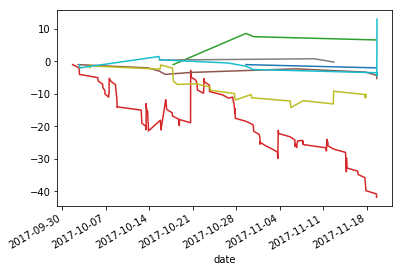

In [524]:
bets_cat = bets.groupby('cat')

print( pd.DataFrame([bets_cat['profit'].mean(), bets_cat['profit'].count()]) )

for cat, b in bets_cat:
    b['profit'].cumsum().plot(label=cat)
